In [1]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from timescoring.annotations import Annotation
from timescoring import scoring, visualization
import os
from utils import *
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from dataloader import testLoader  # Assuming this is your custom data loader
from baselines import CNN_BLSTM, txlstm_szpool, transformer_lstm


In [10]:
x = np.load('/projectnb/seizuredet/Sz-challenge/code/ptlist.npy')
remlist = ['sub-064',
        'sub-078',
        'sub-167',
        'sub-232',
        'sub-245',
        'sub-291',
        'sub-314',]
for i in remlist:
    x = np.delete(x, np.where(x == i))

np.save('/projectnb/seizuredet/Sz-challenge/code/newptlist.npy', x)

In [2]:
import pyedflib
def EDFRead(filename, ns,
            root_dir = '',
           req_chns = ['FP1','FP2','F7','F3','FZ','F4','F8','T3','C3','CZ','C4','T4','T5','P3','PZ','P4','T6','O1','O2'], 
           ):
    
    f = pyedflib.EdfReader(root_dir+filename)
    n = f.signals_in_file
    data =  {key: None for key in req_chns}
    fs = {key: None for key in req_chns}
    for i in range(n):
        
        chn = str(f.signal_label(i)).split('-')[0].split('\'')[1].upper()
        if chn in req_chns:
           
            data[chn] = f.readSignal(i)                
            fs[chn] = f.getSampleFrequencies()[i]

    f.close()
    for chn in req_chns:
        if fs[chn] == None:                
                data[chn] = np.zeros(ns)
                fs[chn] = fs['FP1']
      
    data = np.array(list(data.values()))
    fs = np.array(list(fs.values()))
    #print(data.shape, fs)
    return data, fs

In [3]:
output_dir = '/projectnb/seizuredet/Sz-challenge/testing-pipeline/'
def crop_and_save(data, tsv_data, save_path, subject, session, file_id):
    duration = data.shape[0]
    window = 600  # 10 minutes
    overlap = 120  # 2 minutes
    stride = window - overlap
    leftover = (duration - window) % (window - overlap)
    data_dir = save_path + 'data'
    tsv_dir = save_path + 'annotations'
    
    saved_files = []
    
    for i in range(0, duration, stride):
        end = min(i + window, duration)
        segment = data[i:end]
        
        seg_tsv = []
        
        for _, event in tsv_data.iterrows():
            if event['eventType'] == 'bckg':
                continue
                
            sz_start = event['onset']
            sz_end = sz_start + event['duration']
            
            # Check if seizure overlaps with current segment
            if sz_end > i and sz_start < end:
                # overlap
                overlap_start = max(sz_start, i)
                overlap_end = min(sz_end, end)
                
                # Adjust times 
                new_onset = max(0, overlap_start - i)
                new_duration = overlap_end - overlap_start
                
                seg_tsv.append({
                    'onset': new_onset,
                    'duration': new_duration,
                    'eventType': event['eventType'],
                    'confidence': event['confidence'],
                    'channels': event['channels'],
                    'dateTime': event['dateTime'],
                    'recordingDuration': float(window)
                })
        
        if len(seg_tsv) > 0:
            seg_tsv = pd.DataFrame(seg_tsv)
        else:
            # Add background event if no seizures
            seg_tsv = pd.DataFrame([{
                'onset': 0.0,
                'duration': float(window),
                'eventType': 'bckg',
                'confidence': 1.0,
                'channels': 'n/a',
                'dateTime': tsv_data['dateTime'].iloc[0],
                'recordingDuration': float(window)
            }])
        
        # padding if needed
        if end == duration and leftover > 0 and np.shape(segment)[0] >= 420:
                if len(seg_tsv[seg_tsv['eventType'] != 'bckg']) > 0:
                    segment = pad_segment(segment)
        
        if np.shape(segment)[0] < 420:
            continue
        
        seg_name = f"{subject}/{session}/{file_id}_seg{i//stride:03d}"
        np.save(data_dir + f"/{seg_name}.npy", segment)
        seg_tsv.to_csv(tsv_dir + f"/{seg_name}.tsv", sep='\t', index=False)
        saved_files.append(seg_name)
        
    return saved_files

def label_and_save(save_path, segment_name):
    
    label_dir = save_path + 'labels'
    
    labels = np.zeros(600)
    tsv_data = pd.read_csv(f"{save_path}annotations/{segment_name}.tsv", sep='\t')
    for _, row in tsv_data.iterrows():
        if row['eventType'] != 'bckg':
            start = int(row['onset'])
            end = int((row['onset'] + row['duration']))
            if start < len(labels):
                labels[start:min(end, len(labels))] = 1
                
    np.save(label_dir + f"/{segment_name}_labels.npy", labels)



def pad_segment(data):
    
    duration = data.shape[0]
    if duration >= 600:
        return data
        
    pad_length = 600 - duration
    padding = np.zeros((pad_length, 19, 256))
    
    padded_data = np.concatenate([data, padding], axis=0)
    
    return padded_data

    
def prepare(dataset):
    sampling_rate = 256

    root = f'/projectnb/seizuredet/Sz-challenge/{dataset}/unprocessed/'
    save = f'/projectnb/seizuredet/Sz-challenge/testing/'





    # subjects = os.listdir(root)
    # subjects = list(filter(lambda x: x.startswith('sub-'), subjects))



    subjects = ['sub-232']
    # TESTING PURPOSES
    
    
    count = 0
    for subfol in subjects:
        for sess in os.listdir(root+subfol):
            if sess != 'ses-01':
                continue
            # TESTING PURPOSES


            files = os.listdir(root+subfol+'/'+sess+'/eeg/')
            os.makedirs(save+'data/'+subfol+'/'+sess+'/', exist_ok=True)
            os.makedirs(save+'labels/'+subfol+'/'+sess+'/', exist_ok=True)
            os.makedirs(save+'annotations/'+subfol+'/'+sess+'/', exist_ok=True)
            edffiles = list(filter(lambda x: x.endswith('.edf'), files))
            tsvfiles = list(filter(lambda x: x.endswith('.tsv'), files))
            edffiles = sorted(edffiles)
            tsvfiles = sorted(tsvfiles)
            for curredf, currtsv in zip(edffiles, tsvfiles):
                df=pd.read_csv(root+subfol+'/'+sess+'/eeg/'+currtsv,sep='\t')
                duration = df['recordingDuration'][0]
                if (df['eventType']!='bckg').sum() == 0 or duration > 10000:
                    continue #discard if no seizure or duration < 5 min
                
                x = curredf.split('.')[0].split('_')
                # print(x[0], x[1], x[3], duration)
                ns = int(duration * sampling_rate)
                data, _ = EDFRead(curredf.split("eeg/")[0], ns, root+subfol+'/'+sess+'/eeg/')
                

                data = preprocess(data, 256)
                # print(data.shape)
                data = data.reshape(data.shape[0], int(duration), sampling_rate).transpose(1,0,2)
                # print(data.shape)


                if data.shape[0] < 600:
                    data = pad_segment(data)
                    df['recordingDuration'] = 600.



                    label = np.zeros(600)
                    for _, row in df.iterrows():
                        if row['eventType'] != 'bckg':
                            start = int(row['onset'])
                            end = int(row['onset'] + row['duration'])
                            label[start:min(end, 600)] = 1


                    np.save(save+'labels/'+subfol+'/'+sess+'/'+curredf.split('.')[0]+'_labels.npy', label)
                    np.save(save+'data/'+subfol+'/'+sess+'/'+curredf.split('.')[0]+'.npy', data)
                    df.to_csv(save+'annotations/'+subfol+'/'+sess+'/'+curredf.split('.')[0]+'.tsv', sep='\t', index=False)

                else:

                    files = crop_and_save(data, df, save, subfol, sess, curredf.split('.')[0])
                    for f in files:
                        label_and_save(save, f)

In [6]:
prepare('tuh-bids')

In [21]:
# PIPELINE:

# if discarding:

# we have some 1297-length eeg file
# store the length in a variable
# we splice data into 600, 600, 337, and throw out the 337
# we generate labels for 600 and 600 and save them
# somehow also run labels on the 337
# we run inference on the data, return two predictions arrays of 600, 600
# merge the labels back into 1297

# algorithmically (hardmax) merge predictions into 1080
# zero pad the remaining to get the predictions back into 1297


# if not discarding:
# we have some 1400-length eeg file
# store the length in a variable
# we splice data into 600, 600, 440, and zero pad the 440 until 600
# we generate labels for 600, 600, and 600 and save

# we run inference on the data, return three predictions arrays of 600, 600, 600
# merge the labels into 1560
# algorithmically (hardmax) merge predictions into 1560
# last step: cut the label and prediction arrays back into 1400

# for both: run eval(l,p)

In [15]:
def crop_and_save(data, tsv_data, save_path, subject, session, file_id):
    duration = data.shape[0]
    window = 600  # 10 minutes
    overlap = 120  # 2 minutes
    stride = window - overlap
    leftover = (duration - window) % (window - overlap)
    data_dir = save_path + 'data'
    tsv_dir = save_path + 'annotations'
    extra_data_dir = save_path + 'extra_data'
    extra_label_dir = save_path + 'extra_label'

    
    saved_files = []
    
    for i in range(0, duration, stride):
        end = min(i + window, duration)
        segment = data[i:end]
        seg_tsv = []
        
        for _, event in tsv_data.iterrows():
            if event['eventType'] == 'bckg':
                continue
                
            sz_start = event['onset']
            sz_end = sz_start + event['duration']
            
            # Check if seizure overlaps with current segment
            if sz_end > i and sz_start < end:
                # overlap
                overlap_start = max(sz_start, i)
                overlap_end = min(sz_end, end)
                
                # Adjust times 
                new_onset = max(0, overlap_start - i)
                new_duration = overlap_end - overlap_start
                
                seg_tsv.append({
                    'onset': new_onset,
                    'duration': new_duration,
                    'eventType': event['eventType'],
                    'confidence': event['confidence'],
                    'channels': event['channels'],
                    'dateTime': event['dateTime'],
                    'recordingDuration': float(window)
                })
        
        if len(seg_tsv) > 0:
            seg_tsv = pd.DataFrame(seg_tsv)
        else:
            # Add background event if no seizures
            seg_tsv = pd.DataFrame([{
                'onset': 0.0,
                'duration': float(window),
                'eventType': 'bckg',
                'confidence': 1.0,
                'channels': 'n/a',
                'dateTime': tsv_data['dateTime'].iloc[0],
                'recordingDuration': float(window)
            }])
        
        # padding if needed
        x = np.shape(segment)[0]
        if end == duration and leftover > 0 and np.shape(segment)[0] >= 420:
                if len(seg_tsv[seg_tsv['eventType'] != 'bckg']) > 0:
                    segment = pad_segment(segment)
        
        if np.shape(segment)[0] < 420:
            seg_name = f"{subject}/{session}/{file_id}_seg{i//stride:03d}"
            np.save(extra_data_dir + f"/{seg_name}.npy", segment)
            seg_tsv.to_csv(tsv_dir + f"/{seg_name}.tsv", sep='\t', index=False)
            saved_files.append(seg_name)
        else:
            seg_name = f"{subject}/{session}/{file_id}_seg{i//stride:03d}"
            np.save(data_dir + f"/{seg_name}.npy", segment)
            seg_tsv.to_csv(tsv_dir + f"/{seg_name}.tsv", sep='\t', index=False)
            saved_files.append(seg_name)
            if end == duration:
                break
        
        
    return saved_files, x # pre padding

def label_and_save(save_path, segment_name, flag=True):
    
    label_dir = save_path + 'labels' if not flag else save_path + 'extra_label'
    temp_data = None
    if not flag:
        labels = np.zeros(600)
    else:
        temp_data = np.load(save_path + 'extra_data/' + segment_name + '.npy')

        labels = np.zeros(temp_data.shape[0])

    tsv_data = pd.read_csv(f"{save_path}annotations/{segment_name}.tsv", sep='\t')
    for _, row in tsv_data.iterrows():
        if row['eventType'] != 'bckg':
            start = int(row['onset'])
            end = int((row['onset'] + row['duration']))
            if start < len(labels):
                labels[start:min(end, len(labels))] = 1
                
    np.save(label_dir + f"/{segment_name}_labels.npy", labels)
    del temp_data



def pad_segment(data):
    
    duration = data.shape[0]
    if duration >= 600:
        return data
        
    pad_length = 600 - duration
    padding = np.zeros((pad_length, 19, 256))
    
    padded_data = np.concatenate([data, padding], axis=0)
    
    return padded_data




def vis(m, fold, init, filelist, dataset):
        '''
        filelist is just a single .edf recording worth of 10-min segments (and leftover)
        '''
        init = '_initial' if init else ''
        model_path = f'/projectnb/seizuredet/Sz-challenge/repeated_crossval{init}/baselines/{m}/outer_{fold}/outer_0_best_trained.pth.tar'
        model = txlstm_szpool() if m == 'txlstm' else CNN_BLSTM()
        statedict = torch.load(model_path, map_location=torch.device('cpu'))
        model.load_state_dict(statedict)
        # model.eval()  # Set the model to evaluation mode

        predictions = []
        true_labels = []
        val_set = testLoader(filelist, dataset)
        validation_loader = DataLoader(val_set, batch_size=1, shuffle=False)
        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

        
        for i, data in enumerate(validation_loader):
                inputs = data['buffers'].to(device)
                det_labels = data['sz_labels'].to(device)

                with torch.no_grad():
                # Forward pass
                        if m == 'cnnblstm':
                                k_pred, hc, _  = model(inputs)
                        elif m == 'txlstm':
                                k_pred, hc, _, _  = model(inputs)
                        else:
                                k_pred, hc, _  = model(inputs)

                        pred_labels = k_pred.squeeze()
                        pred_labels = torch.softmax(pred_labels, dim=1)
                        pred_labels = pred_labels.float()
                        

                # print(probabilities.sum())

                # probabilities = torch.softmax(probabilities, dim=-1)
                # print(probabilities)

                # Store predictions and labels
                p = pred_labels.cpu().tolist()
                l = det_labels.cpu().tolist()[0]
                if i == 0:
                    predictions.extend(p)  # Assuming class 1 is positive
                    true_labels.extend(l)
                else:
                    predictions[-120:] = max(predictions[-120:], p[:120])
                    predictions.extend(p[120:])
                    true_labels[-120:] = max(true_labels[-120:], l[:120])
                    true_labels.extend(l[120:])
                    
                     
        # true_labels = true_labels.squeeze(axis=1)
        return predictions, true_labels





    
def pipeline(dataset):
    sampling_rate = 256

    root = f'/projectnb/seizuredet/Sz-challenge/{dataset}/unprocessed/'
    save = f'/projectnb/seizuredet/Sz-challenge/{dataset}/processed/'





    # subjects = os.listdir(root)
    # subjects = list(filter(lambda x: x.startswith('sub-'), subjects))



    subjects = ['sub-00']
    # TESTING PURPOSES
    
    
    count = 0
    for subfol in subjects:
        for sess in os.listdir(root+subfol):
            if sess != 'ses-01':
                continue
            # TESTING PURPOSES


            files = os.listdir(root+subfol+'/'+sess+'/eeg/')
            os.makedirs(save+'data/'+subfol+'/'+sess+'/', exist_ok=True)
            os.makedirs(save+'labels/'+subfol+'/'+sess+'/', exist_ok=True)
            os.makedirs(save+'annotations/'+subfol+'/'+sess+'/', exist_ok=True)
            os.makedirs(save+'extra_data/'+subfol+'/'+sess+'/', exist_ok=True)
            os.makedirs(save+'extra_label/'+subfol+'/'+sess+'/', exist_ok=True)

            edffiles = list(filter(lambda x: x.endswith('.edf'), files))
            tsvfiles = list(filter(lambda x: x.endswith('.tsv'), files))
            edffiles = sorted(edffiles)
            tsvfiles = sorted(tsvfiles)
            for curredf, currtsv in zip(edffiles, tsvfiles):
                df=pd.read_csv(root+subfol+'/'+sess+'/eeg/'+currtsv,sep='\t')
                duration = df['recordingDuration'][0]
                if (df['eventType']!='bckg').sum() == 0 or duration > 10000 or duration < 600:
                    continue #discard if no seizure or duration < 5 min
                
                x = curredf.split('.')[0].split('_')
                # print(x[0], x[1], x[3], duration)
                ns = int(duration * sampling_rate)
                data, _ = EDFRead(curredf.split("eeg/")[0], ns, root+subfol+'/'+sess+'/eeg/')
                

                data = preprocess(data, 256)
                # print(data.shape)
                data = data.reshape(data.shape[0], int(duration), sampling_rate).transpose(1,0,2)
                # print(data.shape)

                files = []
                


                files, leftover = crop_and_save(data, df, save, subfol, sess, curredf.split('.')[0])


                flag = leftover >= 420 
                print(files)
                for i in range(len(files)):
                    f = files[i]
                    input_bool = False
                    if i == len(files) - 1 and not flag:
                        input_bool = True

                    label_and_save(save, f, input_bool)

                # done with first stage of the pipeline, now we have every individual numpy array for the .edf file at hand
                # we can now run inference on each of these files





                # unclear
                # take last segment, extend and zero pad
                if (duration - 600) % 480 == 0:
                    predictions, true_labels = vis('txlstm', 5, False, files, dataset)
                    predictions = np.array(predictions)
                    predictions = (predictions[:, 1] > 0.5)
                    predictions = predictions.tolist()
                elif leftover <= 420:
                    predictions, true_labels = vis('txlstm', 5, False, files[:-1], dataset)
                    predictions = np.array(predictions)
                    predictions = (predictions[:, 1] > 0.5)
                    predictions = predictions.tolist()
                    last = np.load(f'/projectnb/seizuredet/Sz-challenge/{dataset}/processed/extra_label/{files[-1]}_labels.npy').tolist()
                    true_labels[-120:] = max(true_labels[-120:], last[:120])
                    true_labels.extend(last[120:])
                    temp = np.zeros(leftover-120)
                    predictions.extend(temp.tolist())
                else:
                    predictions, true_labels = vis('txlstm', 5, False, files, dataset)
                    predictions = np.array(predictions)
                    predictions = (predictions[:, 1] > 0.5)
                    predictions = predictions.tolist()
                    predictions = predictions[:int(duration)]
                    true_labels = true_labels[:int(duration)]
                
                # print("TL:", true_labels)
                # print("P:", predictions)


                predictions = [x == 1 for x in predictions]
                true_labels = [x == 1 for x in true_labels]
                
                # Define the sampling frequency (fs) in Hz (e.g., 1 sample per second)
                fs = 1  
                num_samples = len(true_labels)

                # Create Annotation objects from binary masks
                
                ref_annotation = Annotation(true_labels, fs)
                hyp_annotation = Annotation(predictions, fs)

                # Define event scoring parameters
                params = scoring.EventScoring.Parameters(
                    toleranceStart=30,      # Allow a 30-second early detection margin
                    toleranceEnd=60,        # Allow a 60-second late detection margin
                    minOverlap=0.5,         # Minimum 50% overlap for a true positive event
                    maxEventDuration=5*60,  # Max duration of an event (5 minutes)
                    minDurationBetweenEvents=90  # Merge events separated by less than 90 seconds
                )

                # Compute event-based scoring
                event_scores = scoring.EventScoring(ref_annotation, hyp_annotation, params)

                # Print event-based metrics
                print(f"Event-based scoring results:\n"
                    f"- Sensitivity : {event_scores.sensitivity:.2f}\n"
                    f"- Precision   : {event_scores.precision:.2f}\n"
                    f"- F1-score    : {event_scores.f1:.2f}\n"
                    f"- False Positives per 24h : {event_scores.fpRate:.2f}")

                # Optional: Visualize event scoring results
                fig = visualization.plotEventScoring(ref_annotation, hyp_annotation, params)
                fig.show()
                     
                     



    



In [11]:
def crop_and_save(data, tsv_data, save_path, subject, session, file_id):
    duration = data.shape[0]
    window = 600  # 10 minutes
    overlap = 120  # 2 minutes
    stride = window - overlap
    leftover = (duration - window) % (window - overlap)
    data_dir = save_path + 'data'
    tsv_dir = save_path + 'annotations'
    
    saved_files = []
    
    for i in range(0, duration, stride):
        end = min(i + window, duration)
        segment = data[i:end]
        seg_tsv = []
        
        for _, event in tsv_data.iterrows():
            if event['eventType'] == 'bckg':
                continue
                
            sz_start = event['onset']
            sz_end = sz_start + event['duration']
            
            # Check if seizure overlaps with current segment
            if sz_end > i and sz_start < end:
                # overlap
                overlap_start = max(sz_start, i)
                overlap_end = min(sz_end, end)
                
                # Adjust times 
                new_onset = max(0, overlap_start - i)
                new_duration = overlap_end - overlap_start
                
                seg_tsv.append({
                    'onset': new_onset,
                    'duration': new_duration,
                    'eventType': event['eventType'],
                    'confidence': event['confidence'],
                    'channels': event['channels'],
                    'dateTime': event['dateTime'],
                    'recordingDuration': float(window)
                })
        
        if len(seg_tsv) > 0:
            seg_tsv = pd.DataFrame(seg_tsv)
        else:
            # Add background event if no seizures
            seg_tsv = pd.DataFrame([{
                'onset': 0.0,
                'duration': float(window),
                'eventType': 'bckg',
                'confidence': 1.0,
                'channels': 'n/a',
                'dateTime': tsv_data['dateTime'].iloc[0],
                'recordingDuration': float(window)
            }])
        
        # padding
        x = np.shape(segment)[0]
        if end == duration and leftover > 0:
                segment = pad_segment(segment)
        
        
        seg_name = f"{subject}/{session}/{file_id}_seg{i//stride:03d}"
        np.save(data_dir + f"/{seg_name}.npy", segment)
        seg_tsv.to_csv(tsv_dir + f"/{seg_name}.tsv", sep='\t', index=False)
        saved_files.append(seg_name)
        if end == duration:
            break
        
        
    return saved_files, x # pre padding

def label_and_save(save_path, segment_name):
    
    label_dir = save_path + 'labels'
    labels = np.zeros(600)
    

    tsv_data = pd.read_csv(f"{save_path}annotations/{segment_name}.tsv", sep='\t')
    for _, row in tsv_data.iterrows():
        if row['eventType'] != 'bckg':
            start = int(row['onset'])
            end = int((row['onset'] + row['duration']))
            if start < len(labels):
                labels[start:min(end, len(labels))] = 1
                
    np.save(label_dir + f"/{segment_name}_labels.npy", labels)



def pad_segment(data):
    
    duration = data.shape[0]
    if duration >= 600:
        return data
        
    pad_length = 600 - duration
    padding = np.zeros((pad_length, 19, 256))
    
    padded_data = np.concatenate([data, padding], axis=0)
    
    return padded_data




def vis(m, fold, init, filelist, dataset):
        '''
        filelist is just a single .edf recording worth of 10-min segments (and leftover)
        '''
        init = '_initial' if init else ''
        model_path = f'/projectnb/seizuredet/Sz-challenge/repeated_crossval{init}/baselines/{m}/outer_{fold}/outer_0_best_trained.pth.tar'
        model = txlstm_szpool() if m == 'txlstm' else CNN_BLSTM()
        statedict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=True)
        model.load_state_dict(statedict)
        # model.eval()  # Set the model to evaluation mode

        predictions = []
        true_labels = []

        dataset = 'testing'
        # CHANGE LATER !!!!!!!!!


        val_set = testLoader(filelist, dataset)
        validation_loader = DataLoader(val_set, batch_size=1, shuffle=False)
        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

        
        for i, data in enumerate(validation_loader):
                inputs = data['buffers'].to(device)
                det_labels = data['sz_labels'].to(device)

                with torch.no_grad():
                # Forward pass
                        if m == 'cnnblstm':
                                k_pred, hc, _  = model(inputs)
                        # REMOVE

                        elif m == 'txlstm':
                                k_pred, hc, _, _  = model(inputs)
                        else:
                                k_pred, hc, _  = model(inputs)

                        pred_labels = k_pred.squeeze()
                        pred_labels = torch.softmax(pred_labels, dim=1)
                        pred_labels = pred_labels.float()
                        

                # print(probabilities.sum())

                # probabilities = torch.softmax(probabilities, dim=-1)
                # print(probabilities)

                # Store predictions and labels
                p = pred_labels.cpu().tolist()
                l = det_labels.cpu().tolist()[0]
                if i == 0:
                    predictions.extend(p)  # Assuming class 1 is positive
                    true_labels.extend(l)
                else:
                    predictions[-120:] = max(predictions[-120:], p[:120])
                    predictions.extend(p[120:])
                    true_labels[-120:] = max(true_labels[-120:], l[:120])
                    true_labels.extend(l[120:])
                    
                     
        # true_labels = true_labels.squeeze(axis=1)
        return predictions, true_labels





    
def pipeline(dataset):
    sampling_rate = 256

    root = f'/projectnb/seizuredet/Sz-challenge/{dataset}/unprocessed/'
    save = f'/projectnb/seizuredet/Sz-challenge/testing/processed/'





    subjects = os.listdir(root)
    subjects = list(filter(lambda x: x.startswith('sub-'), subjects))



    # subjects = [
    #     "sub-291",
    #     "sub-232",
    #     "sub-133",
    #     "sub-378",
    #     "sub-373",
    #     "sub-350",
    #     "sub-078",
    #     "sub-356",
    #     "sub-245",
    #     "sub-064",
    #     "sub-167",
    #     "sub-375",
    #     "sub-067",
    #     "sub-314",
    #     "sub-220",
    #     "sub-145",
    #     "sub-022",
    #     # "sub-332",
    #     # "sub-146",
    #     # "sub-271",
    #     # "sub-181",
    #     # "sub-250",
    #     # "sub-218",
    #     # "sub-323",
    #     # "sub-049",
    #     # "sub-365",
    #     # "sub-260",
    #     # "sub-348",
    #     # "sub-338",
    #     # "sub-153",
    #     # "sub-056",
    #     # "sub-130",
    #     # "sub-318",
    #     # "sub-368"
    #     ]
    # TESTING PURPOSES
    
    
    count = 0
    overall_sensitivity = []
    overall_precision = []
    overall_f1 = []
    overall_fpRate = []

    for subfol in subjects:
        subject_sensitivity = []
        subject_precision = []
        subject_f1 = []
        subject_fpRate = []

        for sess in os.listdir(root+subfol):
            
            # TESTING PURPOSES


            files = os.listdir(root+subfol+'/'+sess+'/eeg/')
            os.makedirs(save+'data/'+subfol+'/'+sess+'/', exist_ok=True)
            os.makedirs(save+'labels/'+subfol+'/'+sess+'/', exist_ok=True)
            os.makedirs(save+'annotations/'+subfol+'/'+sess+'/', exist_ok=True)
            os.makedirs(save+'extra_data/'+subfol+'/'+sess+'/', exist_ok=True)
            os.makedirs(save+'extra_label/'+subfol+'/'+sess+'/', exist_ok=True)

            edffiles = list(filter(lambda x: x.endswith('.edf'), files))
            tsvfiles = list(filter(lambda x: x.endswith('.tsv'), files))
            edffiles = sorted(edffiles)
            tsvfiles = sorted(tsvfiles)
            for curredf, currtsv in zip(edffiles, tsvfiles):
                df=pd.read_csv(root+subfol+'/'+sess+'/eeg/'+currtsv,sep='\t')
                duration = df['recordingDuration'][0]
                if (df['eventType']!='bckg').sum() == 0 or duration > 10000 or duration < 600:
                    continue #REMOVE
                
                x = curredf.split('.')[0].split('_')
                # print(x[0], x[1], x[3], duration)
                ns = int(duration * sampling_rate)
                data, _ = EDFRead(curredf.split("eeg/")[0], ns, root+subfol+'/'+sess+'/eeg/')
                

                data = preprocess(data, 256)
                # print(data.shape)
                data = data.reshape(data.shape[0], int(duration), sampling_rate).transpose(1,0,2)
                # print(data.shape)

                files = []
                


                files, leftover = crop_and_save(data, df, save, subfol, sess, curredf.split('.')[0])


                print(files)
                for i in range(len(files)):
                    f = files[i]

                    label_and_save(save, f)
                    # remove saving and reloading


                # done with first stage of the pipeline, now we have every individual numpy array for the .edf file at hand
                # we can now run inference on each of these files



                # 600, 1080, 1560

                # unclear
                # take last segment, extend and zero pad
                if (duration - 600) % 480 == 0:
                    predictions, true_labels = vis('txlstm', 5, False, files, dataset)
                    predictions = np.array(predictions)
                    predictions = (predictions[:, 1] > 0.5)
                    predictions = predictions.tolist()
                # elif leftover <= 420:
                #     predictions, true_labels = vis('txlstm', 5, False, files[:-1], dataset)
                #     predictions = np.array(predictions)
                #     predictions = (predictions[:, 1] > 0.5)
                #     predictions = predictions.tolist()
                #     last = np.load(f'/projectnb/seizuredet/Sz-challenge/{dataset}/processed/extra_label/{files[-1]}_labels.npy').tolist()
                #     true_labels[-120:] = max(true_labels[-120:], last[:120])
                #     true_labels.extend(last[120:])
                #     temp = np.zeros(leftover-120)
                #     predictions.extend(temp.tolist())
                else:
                    predictions, true_labels = vis('txlstm', 5, False, files, dataset)
                    predictions = np.array(predictions)
                    predictions = (predictions[:, 1] > 0.5)
                    predictions = predictions.tolist()
                    predictions = predictions[:int(duration)]
                    true_labels = true_labels[:int(duration)]
                # print("TL:", true_labels)
                # print("P:", predictions)
                

                predictions = [x == 1 for x in predictions]
                true_labels = [x == 1 for x in true_labels]


                

                # Define the sampling frequency (fs) in Hz (e.g., 1 sample per second)
                fs = 1  
                num_samples = len(true_labels)

                # Create Annotation objects from binary masks
                
                ref_annotation = Annotation(true_labels, fs)
                hyp_annotation = Annotation(predictions, fs)

                # Define event scoring parameters
                params = scoring.EventScoring.Parameters(
                    toleranceStart=30,      # Allow a 30-second early detection margin
                    toleranceEnd=60,        # Allow a 60-second late detection margin
                    minOverlap=0,         # Minimum 50% overlap for a true positive event
                    maxEventDuration=5*60,  # Max duration of an event (5 minutes)
                    minDurationBetweenEvents=90  # Merge events separated by less than 90 seconds
                )

                # Compute event-based scoring
                event_scores = scoring.EventScoring(ref_annotation, hyp_annotation, params)

                # Print event-based metrics

                # Handling NaN values in event scores
                if np.isnan(event_scores.precision):
                    event_scores.precision = 0.
                    event_scores.f1 = 0.

                if np.isnan(event_scores.sensitivity):
                    event_scores.sensitivity = 0.
                    event_scores.f1 = 0.

                if np.isnan(event_scores.f1):
                    event_scores.f1 = 0.

                if np.isnan(event_scores.fpRate):
                    event_scores.fpRate = 0.

                # print(f"Event-based scoring results:\n"
                #     f"- Sensitivity : {event_scores.sensitivity:.2f}\n"
                #     f"- Precision   : {event_scores.precision:.2f}\n"
                #     f"- F1-score    : {event_scores.f1:.2f}\n"
                #     f"- False Positives per 24h : {event_scores.fpRate:.2f}")
                
                
                subject_sensitivity.append(event_scores.sensitivity)
                subject_precision.append(event_scores.precision)
                subject_f1.append(event_scores.f1)
                subject_fpRate.append(event_scores.fpRate)



        
                # Optional: Visualize event scoring results
                if subfol == 'sub-13' or subfol == 'sub-05':
                    fig = visualization.plotEventScoring(ref_annotation, hyp_annotation, params)
                    fig.show()
        
        
        if subject_sensitivity:
            overall_sensitivity.append(np.mean(subject_sensitivity))
        if subject_precision:
            overall_precision.append(np.mean(subject_precision))
        if subject_f1:
            overall_f1.append(np.mean(subject_f1))
        if subject_fpRate:
            overall_fpRate.append(np.mean(subject_fpRate))

    print(f"Overall sensitivity: {np.mean(overall_sensitivity)}")
    print(f"Overall precision: {np.mean(overall_precision)}")
    print(f"Overall f1: {np.mean(overall_f1)}")
    print(f"Overall fpRate: {np.mean(overall_fpRate)}")

                     
                     



    



In [12]:
pipeline('siena-bids')

['sub-13/ses-01/sub-13_ses-01_task-szMonitoring_run-00_eeg_seg000', 'sub-13/ses-01/sub-13_ses-01_task-szMonitoring_run-00_eeg_seg001', 'sub-13/ses-01/sub-13_ses-01_task-szMonitoring_run-00_eeg_seg002', 'sub-13/ses-01/sub-13_ses-01_task-szMonitoring_run-00_eeg_seg003', 'sub-13/ses-01/sub-13_ses-01_task-szMonitoring_run-00_eeg_seg004', 'sub-13/ses-01/sub-13_ses-01_task-szMonitoring_run-00_eeg_seg005', 'sub-13/ses-01/sub-13_ses-01_task-szMonitoring_run-00_eeg_seg006', 'sub-13/ses-01/sub-13_ses-01_task-szMonitoring_run-00_eeg_seg007', 'sub-13/ses-01/sub-13_ses-01_task-szMonitoring_run-00_eeg_seg008', 'sub-13/ses-01/sub-13_ses-01_task-szMonitoring_run-00_eeg_seg009', 'sub-13/ses-01/sub-13_ses-01_task-szMonitoring_run-00_eeg_seg010', 'sub-13/ses-01/sub-13_ses-01_task-szMonitoring_run-00_eeg_seg011', 'sub-13/ses-01/sub-13_ses-01_task-szMonitoring_run-00_eeg_seg012', 'sub-13/ses-01/sub-13_ses-01_task-szMonitoring_run-00_eeg_seg013', 'sub-13/ses-01/sub-13_ses-01_task-szMonitoring_run-00_eeg_seg

: 

1. send email of siena results
2. smooth predicted probabilities (5-10s window to remove tiny spikes) -- on deeksha's github
3. as per TUH, threshold should be lower, but check with siena first
4. optimize pipeline in meantime --> ifelse, array ops instead of forloops, don't save and reload, reduce memory access
5. save to .tsv files
6. migrate to szcore-evaluation with new venv





In [87]:
def crop_and_save(data, tsv_data, save_path, subject, session, file_id):
    duration = data.shape[0]
    window = 600  # 10 minutes
    overlap = 120  # 2 minutes
    stride = window - overlap
    leftover = (duration - window) % (window - overlap)
    data_dir = save_path + 'data'
    tsv_dir = save_path + 'annotations'
    
    saved_files = []
    
    for i in range(0, duration, stride):
        end = min(i + window, duration)
        segment = data[i:end]
        seg_tsv = []
        
        for _, event in tsv_data.iterrows():
            if event['eventType'] == 'bckg':
                continue
                
            sz_start = event['onset']
            sz_end = sz_start + event['duration']
            
            # Check if seizure overlaps with current segment
            if sz_end > i and sz_start < end:
                # overlap
                overlap_start = max(sz_start, i)
                overlap_end = min(sz_end, end)
                
                # Adjust times 
                new_onset = max(0, overlap_start - i)
                new_duration = overlap_end - overlap_start
                
                seg_tsv.append({
                    'onset': new_onset,
                    'duration': new_duration,
                    'eventType': event['eventType'],
                    'confidence': event['confidence'],
                    'channels': event['channels'],
                    'dateTime': event['dateTime'],
                    'recordingDuration': float(window)
                })
        
        if len(seg_tsv) > 0:
            seg_tsv = pd.DataFrame(seg_tsv)
        else:
            # Add background event if no seizures
            seg_tsv = pd.DataFrame([{
                'onset': 0.0,
                'duration': float(window),
                'eventType': 'bckg',
                'confidence': 1.0,
                'channels': 'n/a',
                'dateTime': tsv_data['dateTime'].iloc[0],
                'recordingDuration': float(window)
            }])
        
        # padding
        x = np.shape(segment)[0]
        if end == duration and leftover > 0:
                segment = pad_segment(segment)
        
        
        seg_name = f"{subject}/{session}/{file_id}_seg{i//stride:03d}"
        np.save(data_dir + f"/{seg_name}.npy", segment)
        seg_tsv.to_csv(tsv_dir + f"/{seg_name}.tsv", sep='\t', index=False)
        saved_files.append(seg_name)
        if end == duration:
            break
        
        
    return saved_files, x # pre padding

def label_and_save(save_path, segment_name):
    
    label_dir = save_path + 'labels'
    labels = np.zeros(600)
    

    tsv_data = pd.read_csv(f"{save_path}annotations/{segment_name}.tsv", sep='\t')
    for _, row in tsv_data.iterrows():
        if row['eventType'] != 'bckg':
            start = int(row['onset'])
            end = int((row['onset'] + row['duration']))
            if start < len(labels):
                labels[start:min(end, len(labels))] = 1
                
    np.save(label_dir + f"/{segment_name}_labels.npy", labels)



def pad_segment(data):
    
    duration = data.shape[0]
    if duration >= 600:
        return data
        
    pad_length = 600 - duration
    padding = np.zeros((pad_length, 19, 256))
    
    padded_data = np.concatenate([data, padding], axis=0)
    
    return padded_data




def vis(m, fold, init, filelist, dataset):
        '''
        filelist is just a single .edf recording worth of 10-min segments (and leftover)
        '''
        init = '_initial' if init else ''
        # model_path = f'/projectnb/seizuredet/Sz-challenge/repeated_crossval{init}/baselines/{m}/outer_{fold}/outer_0_best_trained.pth.tar'
        # model = txlstm_szpool() if m == 'txlstm' else CNN_BLSTM()
        # statedict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=True)
        # model.load_state_dict(statedict)
        # model.eval()  # Set the model to evaluation mode

        predictions = []
        true_labels = []

        dataset = 'testing'
        # CHANGE LATER !!!!!!!!!


        val_set = testLoader(filelist, dataset)
        validation_loader = DataLoader(val_set, batch_size=1, shuffle=False)
        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

        
        for i, data in enumerate(validation_loader):
                # inputs = data['buffers'].to(device)
                det_labels = data['sz_labels'].to(device)

                # with torch.no_grad():
                # # Forward pass
                #         if m == 'cnnblstm':
                #                 k_pred, hc, _  = model(inputs)
                #         elif m == 'txlstm':
                #                 k_pred, hc, _, _  = model(inputs)
                #         else:
                #                 k_pred, hc, _  = model(inputs)

                #         pred_labels = k_pred.squeeze()
                #         pred_labels = torch.softmax(pred_labels, dim=1)
                #         pred_labels = pred_labels.float()
                        

                # print(probabilities.sum())

                # probabilities = torch.softmax(probabilities, dim=-1)
                # print(probabilities)

                # Store predictions and labels
                # p = pred_labels.cpu().tolist()
                l = det_labels.cpu().tolist()[0]
                if i == 0:
                    # predictions.extend(p)  # Assuming class 1 is positive
                    true_labels.extend(l)
                else:
                    # predictions[-120:] = max(predictions[-120:], p[:120])
                    # predictions.extend(p[120:])
                    true_labels[-120:] = max(true_labels[-120:], l[:120])
                    true_labels.extend(l[120:])
                    
        predictions = np.ones(len(true_labels))
        # true_labels = true_labels.squeeze(axis=1)
        return predictions, true_labels





    
def weird_pipeline(dataset):
    sampling_rate = 256

    root = f'/projectnb/seizuredet/Sz-challenge/{dataset}/unprocessed/'
    save = f'/projectnb/seizuredet/Sz-challenge/testing/processed/'





    # subjects = os.listdir(root)
    # subjects = list(filter(lambda x: x.startswith('sub-'), subjects))



    subjects = ["sub-00",
        # "sub-232",
        # "sub-133",
        # "sub-378",
        # "sub-373",
        # "sub-350",
        # "sub-078",
        # "sub-356",
        # "sub-245",
        # "sub-064",
        # "sub-167",
        # "sub-375",
        # "sub-067",
        # "sub-314",
        # "sub-220",
        # "sub-145",
        # "sub-022"
        ]
    # TESTING PURPOSES
    
    
    count = 0
    overall_sensitivity = []
    overall_precision = []
    overall_f1 = []
    overall_fpRate = []

    for subfol in subjects:
        subject_sensitivity = []
        subject_precision = []
        subject_f1 = []
        subject_fpRate = []

        for sess in os.listdir(root+subfol):

            
            # TESTING PURPOSES


            files = os.listdir(root+subfol+'/'+sess+'/eeg/')
            os.makedirs(save+'data/'+subfol+'/'+sess+'/', exist_ok=True)
            os.makedirs(save+'labels/'+subfol+'/'+sess+'/', exist_ok=True)
            os.makedirs(save+'annotations/'+subfol+'/'+sess+'/', exist_ok=True)
            os.makedirs(save+'extra_data/'+subfol+'/'+sess+'/', exist_ok=True)
            os.makedirs(save+'extra_label/'+subfol+'/'+sess+'/', exist_ok=True)

            edffiles = list(filter(lambda x: x.endswith('.edf'), files))
            tsvfiles = list(filter(lambda x: x.endswith('.tsv'), files))
            edffiles = sorted(edffiles)
            tsvfiles = sorted(tsvfiles)
            for curredf, currtsv in zip(edffiles, tsvfiles):
                df=pd.read_csv(root+subfol+'/'+sess+'/eeg/'+currtsv,sep='\t')
                duration = df['recordingDuration'][0]
                if (df['eventType']!='bckg').sum() == 0 or duration > 10000 or duration < 600:
                    continue #discard if no seizure or duration < 5 min
                
                x = curredf.split('.')[0].split('_')
                # print(x[0], x[1], x[3], duration)
                ns = int(duration * sampling_rate)
                data, _ = EDFRead(curredf.split("eeg/")[0], ns, root+subfol+'/'+sess+'/eeg/')
                

                data = preprocess(data, 256)
                # print(data.shape)
                data = data.reshape(data.shape[0], int(duration), sampling_rate).transpose(1,0,2)
                # print(data.shape)

                files = []
                


                files, leftover = crop_and_save(data, df, save, subfol, sess, curredf.split('.')[0])


                print(files)
                for i in range(len(files)):
                    f = files[i]

                    label_and_save(save, f)

                # done with first stage of the pipeline, now we have every individual numpy array for the .edf file at hand
                # we can now run inference on each of these files





                # unclear
                # take last segment, extend and zero pad
                if (duration - 600) % 480 == 0:
                    predictions, true_labels = vis('txlstm', 5, False, files, dataset)
                    predictions = predictions.tolist()
                # elif leftover <= 420:
                #     predictions, true_labels = vis('txlstm', 5, False, files[:-1], dataset)
                #     predictions = np.array(predictions)
                #     predictions = (predictions[:, 1] > 0.5)
                #     predictions = predictions.tolist()
                #     last = np.load(f'/projectnb/seizuredet/Sz-challenge/{dataset}/processed/extra_label/{files[-1]}_labels.npy').tolist()
                #     true_labels[-120:] = max(true_labels[-120:], last[:120])
                #     true_labels.extend(last[120:])
                #     temp = np.zeros(leftover-120)
                #     predictions.extend(temp.tolist())
                else:
                    predictions, true_labels = vis('txlstm', 5, False, files, dataset)
                    predictions = predictions.tolist()
                    predictions = predictions[:int(duration)]
                    true_labels = true_labels[:int(duration)]
                
                # print("TL:", true_labels)
                # print("P:", predictions)
                

                predictions = [x == 1 for x in predictions]
                true_labels = [x == 1 for x in true_labels]

                if len(true_labels) == 0 or len(predictions) == 0:
                    print("Skipping empty file...")
                    print(files)
                    continue
                

                # Define the sampling frequency (fs) in Hz (e.g., 1 sample per second)
                fs = 1  
                num_samples = len(true_labels)

                # Create Annotation objects from binary masks
                
                ref_annotation = Annotation(true_labels, fs)
                hyp_annotation = Annotation(predictions, fs)

                # Define event scoring parameters
                params = scoring.EventScoring.Parameters(
                    toleranceStart=30,      # Allow a 30-second early detection margin
                    toleranceEnd=60,        # Allow a 60-second late detection margin
                    minOverlap=0.5,         # Minimum 50% overlap for a true positive event
                    maxEventDuration=5*60,  # Max duration of an event (5 minutes)
                    minDurationBetweenEvents=90  # Merge events separated by less than 90 seconds
                )

                # Compute event-based scoring
                event_scores = scoring.EventScoring(ref_annotation, hyp_annotation, params)

                # Print event-based metrics
                

                # Handling NaN values in event scores
                # if np.isnan(event_scores.precision):
                #     event_scores.precision = 0.
                #     event_scores.f1 = 0.

                # if np.isnan(event_scores.sensitivity):
                #     event_scores.sensitivity = 0.
                #     event_scores.f1 = 0.

                # if np.isnan(event_scores.f1):
                #     event_scores.f1 = 0.

                # if np.isnan(event_scores.fpRate):
                #     event_scores.fpRate = 0.

                print(f"Event-based scoring results:\n"
                    f"- Sensitivity : {event_scores.sensitivity:.2f}\n"
                    f"- Precision   : {event_scores.precision:.2f}\n"
                    f"- F1-score    : {event_scores.f1:.2f}\n"
                    f"- False Positives per 24h : {event_scores.fpRate:.2f}")
                
                
                subject_sensitivity.append(event_scores.sensitivity)
                subject_precision.append(event_scores.precision)
                subject_f1.append(event_scores.f1)
                subject_fpRate.append(event_scores.fpRate)



                # Optional: Visualize event scoring results
                fig = visualization.plotEventScoring(ref_annotation, hyp_annotation, params)
                fig.show()
        
        
        if subject_sensitivity:
            overall_sensitivity.append(np.mean(subject_sensitivity))
        if subject_precision:
            overall_precision.append(np.mean(subject_precision))
        if subject_f1:
            overall_f1.append(np.mean(subject_f1))
        if subject_fpRate:
            overall_fpRate.append(np.mean(subject_fpRate))

    print(f"Overall sensitivity: {np.mean(overall_sensitivity)}")
    print(f"Overall precision: {np.mean(overall_precision)}")
    print(f"Overall f1: {np.mean(overall_f1)}")
    print(f"Overall fpRate: {np.mean(overall_fpRate)}")

                     
                     



    



['sub-00/ses-01/sub-00_ses-01_task-szMonitoring_run-00_eeg_seg000', 'sub-00/ses-01/sub-00_ses-01_task-szMonitoring_run-00_eeg_seg001', 'sub-00/ses-01/sub-00_ses-01_task-szMonitoring_run-00_eeg_seg002', 'sub-00/ses-01/sub-00_ses-01_task-szMonitoring_run-00_eeg_seg003', 'sub-00/ses-01/sub-00_ses-01_task-szMonitoring_run-00_eeg_seg004', 'sub-00/ses-01/sub-00_ses-01_task-szMonitoring_run-00_eeg_seg005']
Event-based scoring results:
- Sensitivity : 1.00
- Precision   : 0.12
- F1-score    : 0.22
- False Positives per 24h : 230.40
['sub-00/ses-01/sub-00_ses-01_task-szMonitoring_run-01_eeg_seg000', 'sub-00/ses-01/sub-00_ses-01_task-szMonitoring_run-01_eeg_seg001', 'sub-00/ses-01/sub-00_ses-01_task-szMonitoring_run-01_eeg_seg002', 'sub-00/ses-01/sub-00_ses-01_task-szMonitoring_run-01_eeg_seg003', 'sub-00/ses-01/sub-00_ses-01_task-szMonitoring_run-01_eeg_seg004']
Event-based scoring results:
- Sensitivity : 1.00
- Precision   : 0.14
- F1-score    : 0.25
- False Positives per 24h : 225.20
['sub-0

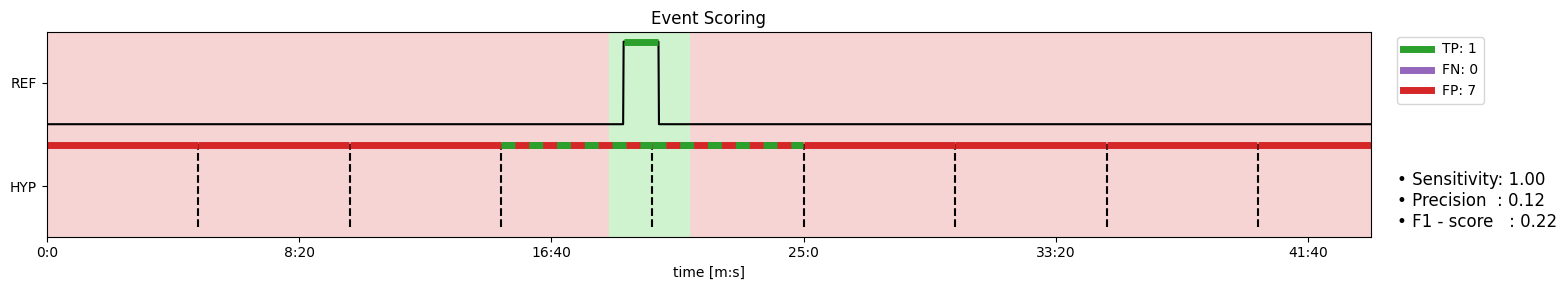

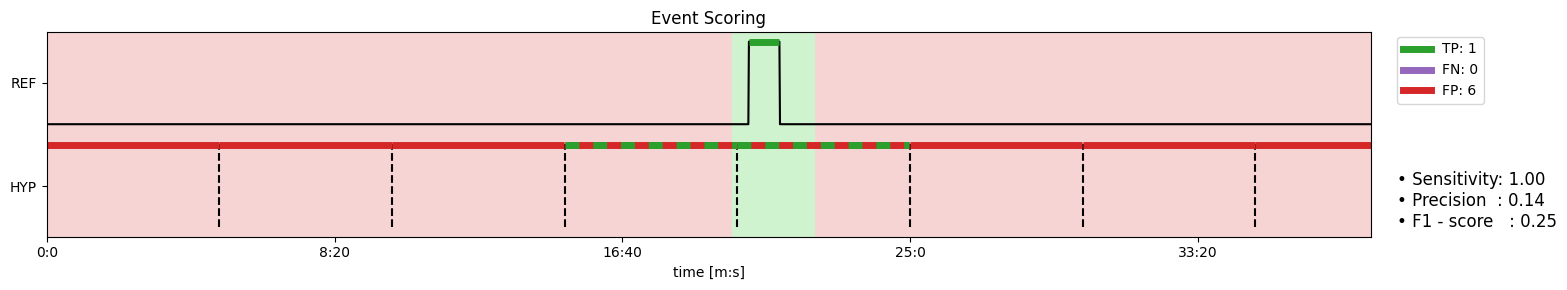

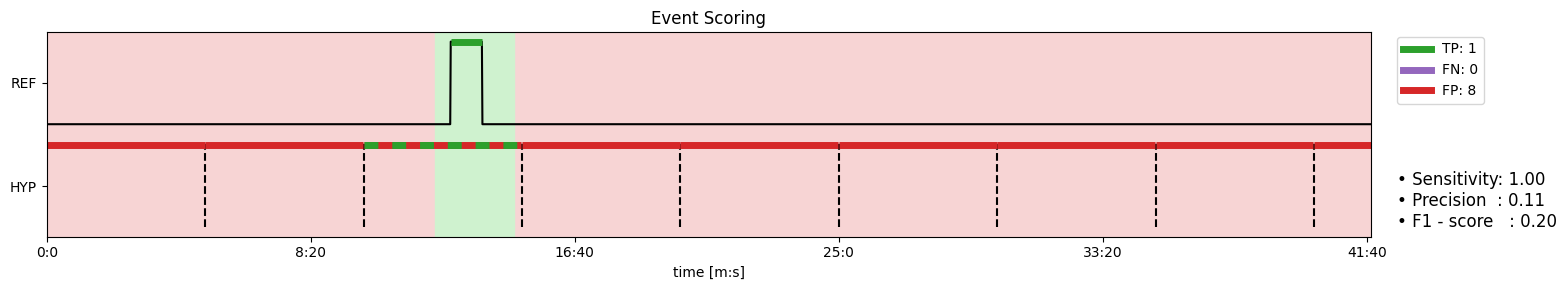

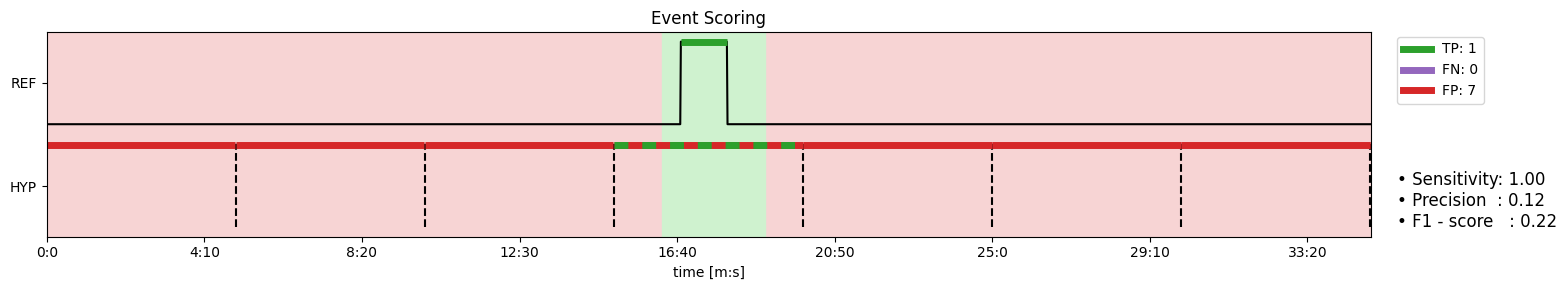

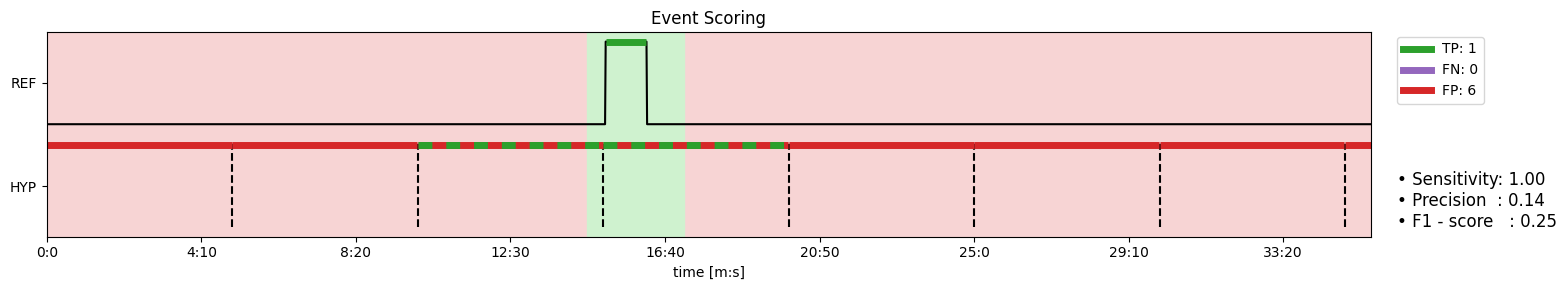

In [88]:
weird_pipeline('siena-bids')